## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

### 1. 試比較有 BN 在 Batch_size = 1024, 512, 256, 128 下的差異

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(x)
            x = BatchNormalization()(x)
            
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [6]:
# Hyperparams
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [1024, 512, 256, 128]
MOMENTUM = 0.95

In [7]:
results = {}
for i in BATCH_SIZE:
    keras.backend.clear_session()
    print('Experiment with batch size = %d'%i)
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=i,
             validation_data=(x_test, y_test),
             shuffle=True)
    
    # Collect data
    exp_name_tag = 'batch-size-%d'%i
    results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                            'valid_loss': model.history.history['val_loss'],
                            'train_acc': model.history.history['accuracy'],
                            'valid_acc': model.history.history['val_accuracy']}

Experiment with batch size = 1024
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________

Epoch 42/50
50000/50000 [==============================] - 34s 682us/step - loss: 0.6225 - accuracy: 0.8113 - val_loss: 1.5747 - val_accuracy: 0.4924
Epoch 43/50
50000/50000 [==============================] - 34s 681us/step - loss: 0.6073 - accuracy: 0.8163 - val_loss: 1.5744 - val_accuracy: 0.4908
Epoch 44/50
50000/50000 [==============================] - 35s 693us/step - loss: 0.5893 - accuracy: 0.8239 - val_loss: 1.5914 - val_accuracy: 0.4893
Epoch 45/50
50000/50000 [==============================] - 34s 680us/step - loss: 0.5713 - accuracy: 0.8317 - val_loss: 1.6110 - val_accuracy: 0.4944
Epoch 46/50
50000/50000 [==============================] - 34s 689us/step - loss: 0.5561 - accuracy: 0.8355 - val_loss: 1.6241 - val_accuracy: 0.4876
Epoch 47/50
50000/50000 [==============================] - 35s 692us/step - loss: 0.5391 - accuracy: 0.8440 - val_loss: 1.6542 - val_accuracy: 0.4843
Epoch 48/50
50000/50000 [==============================] - 34s 679us/step - loss: 0.5211 - accuracy:

Epoch 37/50
50000/50000 [==============================] - 36s 724us/step - loss: 0.4559 - accuracy: 0.8646 - val_loss: 1.8084 - val_accuracy: 0.4638
Epoch 38/50
50000/50000 [==============================] - 37s 731us/step - loss: 0.4350 - accuracy: 0.8715 - val_loss: 1.8294 - val_accuracy: 0.4832
Epoch 39/50
50000/50000 [==============================] - 36s 728us/step - loss: 0.4164 - accuracy: 0.8791 - val_loss: 1.8244 - val_accuracy: 0.4881
Epoch 40/50
50000/50000 [==============================] - 35s 709us/step - loss: 0.3991 - accuracy: 0.8855 - val_loss: 1.8057 - val_accuracy: 0.4865
Epoch 41/50
50000/50000 [==============================] - 36s 712us/step - loss: 0.3785 - accuracy: 0.8940 - val_loss: 1.8716 - val_accuracy: 0.4694
Epoch 42/50
50000/50000 [==============================] - 36s 723us/step - loss: 0.3606 - accuracy: 0.8995 - val_loss: 1.8964 - val_accuracy: 0.4837
Epoch 43/50
50000/50000 [==============================] - 37s 732us/step - loss: 0.3415 - accuracy:

50000/50000 [==============================] - 43s 866us/step - loss: 0.4677 - accuracy: 0.8485 - val_loss: 2.0022 - val_accuracy: 0.4690
Epoch 32/50
50000/50000 [==============================] - 39s 785us/step - loss: 0.4414 - accuracy: 0.8569 - val_loss: 2.0210 - val_accuracy: 0.4668
Epoch 33/50
50000/50000 [==============================] - 49s 986us/step - loss: 0.4228 - accuracy: 0.8648 - val_loss: 1.9052 - val_accuracy: 0.4680
Epoch 34/50
50000/50000 [==============================] - 48s 958us/step - loss: 0.4048 - accuracy: 0.8724 - val_loss: 1.9557 - val_accuracy: 0.4711
Epoch 35/50
50000/50000 [==============================] - 42s 846us/step - loss: 0.3805 - accuracy: 0.8793 - val_loss: 1.9642 - val_accuracy: 0.4826
Epoch 36/50
50000/50000 [==============================] - 42s 842us/step - loss: 0.3631 - accuracy: 0.8863 - val_loss: 2.1024 - val_accuracy: 0.4609
Epoch 37/50
50000/50000 [==============================] - 46s 918us/step - loss: 0.3477 - accuracy: 0.8903 - va

50000/50000 [==============================] - 52s 1ms/step - loss: 0.6228 - accuracy: 0.7830 - val_loss: 1.8407 - val_accuracy: 0.4710
Epoch 27/50
50000/50000 [==============================] - 49s 983us/step - loss: 0.6089 - accuracy: 0.7862 - val_loss: 1.9038 - val_accuracy: 0.4522
Epoch 28/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.5866 - accuracy: 0.7934 - val_loss: 1.8358 - val_accuracy: 0.4756
Epoch 29/50
50000/50000 [==============================] - 52s 1ms/step - loss: 0.5603 - accuracy: 0.8047 - val_loss: 1.8637 - val_accuracy: 0.4743
Epoch 30/50
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5286 - accuracy: 0.8181 - val_loss: 2.0329 - val_accuracy: 0.4503
Epoch 31/50
50000/50000 [==============================] - 53s 1ms/step - loss: 0.5071 - accuracy: 0.8260 - val_loss: 1.9738 - val_accuracy: 0.4750
Epoch 32/50
50000/50000 [==============================] - 58s 1ms/step - loss: 0.5048 - accuracy: 0.8264 - val_loss: 2.14

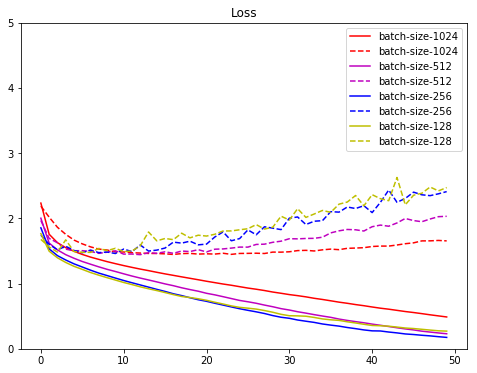

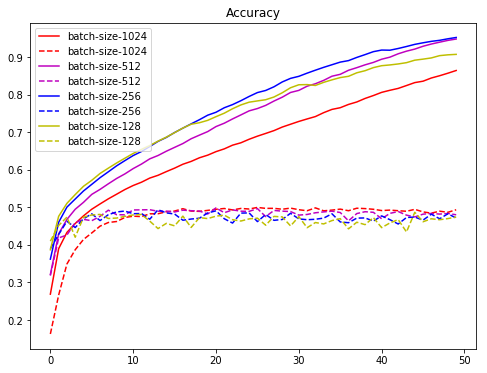

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r', 'm', 'b', 'y', 'k']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
plt.ylim(0, 5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
#plt.ylim(0, 5)
plt.legend()
plt.show()

### 2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [9]:
from keras import activations
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name='hidden_layer%d'%(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Activation(activations.relu)(x)
        else:
            x = keras.layers.Dense(units=n_units, name='hidden_layer%d'%(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation(activations.relu)(x)
            
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [10]:
# Hyperparams
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
keras.backend.clear_session()
print('Experiment with BN before activation function')

model = build_mlp2(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True)

# Collect data
exp_name_tag = 'BN-before-activation'
results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                        'valid_loss': model.history.history['val_loss'],
                        'train_acc': model.history.history['accuracy'],
                        'valid_acc': model.history.history['val_accuracy']}

Experiment with BN before activation function
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 

Epoch 43/50
50000/50000 [==============================] - 35s 697us/step - loss: 0.6464 - accuracy: 0.8110 - val_loss: 1.4689 - val_accuracy: 0.5005
Epoch 44/50
50000/50000 [==============================] - 35s 695us/step - loss: 0.6276 - accuracy: 0.8190 - val_loss: 1.4752 - val_accuracy: 0.5044
Epoch 45/50
50000/50000 [==============================] - 36s 715us/step - loss: 0.6090 - accuracy: 0.8240 - val_loss: 1.4871 - val_accuracy: 0.5046
Epoch 46/50
50000/50000 [==============================] - 35s 708us/step - loss: 0.5901 - accuracy: 0.8340 - val_loss: 1.4938 - val_accuracy: 0.5014
Epoch 47/50
50000/50000 [==============================] - 35s 703us/step - loss: 0.5712 - accuracy: 0.8406 - val_loss: 1.5051 - val_accuracy: 0.5072
Epoch 48/50
50000/50000 [==============================] - 36s 717us/step - loss: 0.5547 - accuracy: 0.8470 - val_loss: 1.5014 - val_accuracy: 0.5040
Epoch 49/50
50000/50000 [==============================] - 36s 718us/step - loss: 0.5356 - accuracy:

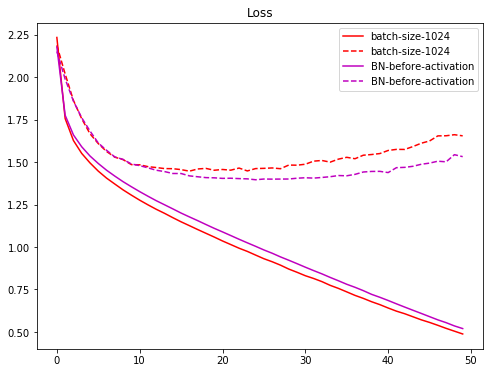

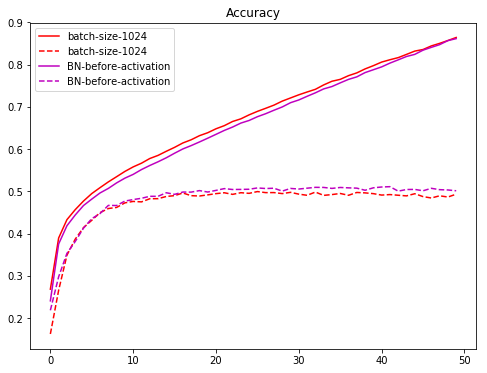

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r', 'm']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(['batch-size-1024', 'BN-before-activation']):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
#plt.ylim(0, 5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(['batch-size-1024', 'BN-before-activation']):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
#plt.ylim(0, 5)
plt.legend()
plt.show()

### 3. 請於 BN 放在 Input Layer 後，並比較結果

In [13]:
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(x)
        x = BatchNormalization()(x)
            
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [14]:
# Hyperparams
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
keras.backend.clear_session()
print('Experiment with BN after input layer')

model = build_mlp3(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True)

# Collect data
exp_name_tag = 'BN-after-input'
results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                        'valid_loss': model.history.history['val_loss'],
                        'train_acc': model.history.history['accuracy'],
                        'valid_acc': model.history.history['val_accuracy']}

Experiment with BN after input layer
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense) 

50000/50000 [==============================] - 55s 1ms/step - loss: 0.3762 - accuracy: 0.9137 - val_loss: 1.7117 - val_accuracy: 0.4941
Epoch 46/50
50000/50000 [==============================] - 55s 1ms/step - loss: 0.3594 - accuracy: 0.9197 - val_loss: 1.7251 - val_accuracy: 0.4942
Epoch 47/50
50000/50000 [==============================] - 55s 1ms/step - loss: 0.3403 - accuracy: 0.9271 - val_loss: 1.7340 - val_accuracy: 0.4983
Epoch 48/50
50000/50000 [==============================] - 55s 1ms/step - loss: 0.3236 - accuracy: 0.9346 - val_loss: 1.7594 - val_accuracy: 0.4899
Epoch 49/50
50000/50000 [==============================] - 56s 1ms/step - loss: 0.3070 - accuracy: 0.9397 - val_loss: 1.7778 - val_accuracy: 0.4927
Epoch 50/50
50000/50000 [==============================] - 56s 1ms/step - loss: 0.2924 - accuracy: 0.9445 - val_loss: 1.7980 - val_accuracy: 0.4921


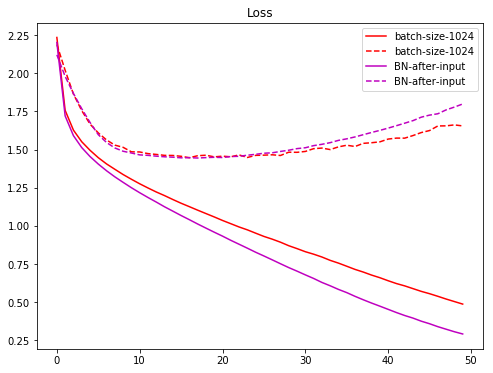

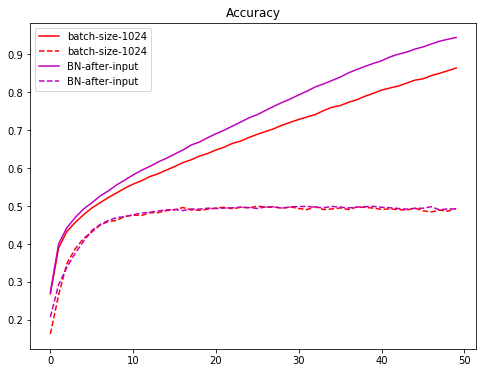

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r', 'm']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(['batch-size-1024', 'BN-after-input']):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
#plt.ylim(0, 5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(['batch-size-1024', 'BN-after-input']):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
#plt.ylim(0, 5)
plt.legend()
plt.show()